In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Set seeds for reproducibility
import random
random.seed(0)

import numpy as np
np.random.seed(0)

import tensorflow as tf
tf.random.set_seed(0)

In [3]:
import os
import json
from zipfile import ZipFile
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [4]:
with ZipFile("/content/drive/MyDrive/DatasetMy/Diseases.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [5]:
!ls {/content/Diseases}

ls: cannot access '{/content/Diseases}': No such file or directory


In [6]:
print(len(os.listdir("/content/Diseases/Bacterial_Spot_Pepper")))
print(os.listdir("/content/Diseases/Bacterial_Spot_Pepper")[:5])

997
['836b4b9e-85d5-47bc-ad93-9ab31b07be3d___JR_B.Spot 3361.JPG', '3bb93b52-4419-4882-9a35-0533f48757df___JR_B.Spot 3311.JPG', '77a0bad6-8570-43a4-b521-306b2cb0739a___JR_B.Spot 8960.JPG', '39d02156-2d42-4927-aab3-20dd59810f69___NREC_B.Spot 9075.JPG', '4a18013a-dcd1-4974-b841-89c49b198a11___NREC_B.Spot 1984.JPG']


In [7]:
print(len(os.listdir("/content/Diseases")))
print(os.listdir("/content/Diseases")[:5])

9
['Healthy_Corn', 'Healthy_Pepper', 'Healthy_Cotton_Leaf', 'Bacterial_Spot_Pepper', 'Diseased_Cotton_Plant']


In [8]:
base_dir = '/content/Diseases'

(256, 256, 3)


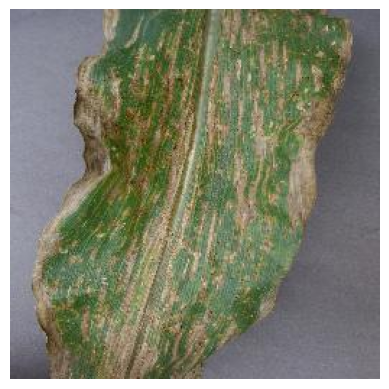

In [9]:
image_path = '/content/Diseases/Gray_Leaf_Spot_Corn/image (1).JPG'

# Read the image
img = mpimg.imread(image_path)

print(img.shape)
# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers
plt.show()

In [10]:
image_path = '/content/Diseases/Gray_Leaf_Spot_Corn/image (10).JPG'

# Read the image
img = mpimg.imread(image_path)

print(img)

[[[ 81  67  41]
  [ 77  65  39]
  [ 80  71  42]
  ...
  [ 87  88 108]
  [ 92  93 113]
  [ 96  97 117]]

 [[ 75  61  35]
  [ 75  63  37]
  [ 83  76  47]
  ...
  [ 93  94 114]
  [ 93  94 114]
  [ 93  94 114]]

 [[ 73  61  35]
  [ 78  68  41]
  [ 88  83  53]
  ...
  [ 98  99 119]
  [ 95  96 116]
  [ 91  92 112]]

 ...

 [[166 165 179]
  [167 166 180]
  [169 168 182]
  ...
  [157 156 170]
  [158 157 175]
  [146 147 165]]

 [[165 164 178]
  [167 166 180]
  [169 168 182]
  ...
  [147 149 164]
  [152 153 173]
  [152 155 174]]

 [[166 165 179]
  [167 166 180]
  [169 168 182]
  ...
  [146 147 165]
  [142 145 164]
  [148 150 171]]]


In [11]:
# Image Parameters
img_size = 224
batch_size = 32

In [12]:
# Image Data Generators
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use 20% of data for validation
)

In [13]:
# Train Generator
train_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)

Found 5455 images belonging to 9 classes.


In [14]:
# Validation Generator
validation_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)

Found 1360 images belonging to 9 classes.


In [19]:
# Model Definition
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(layers.MaxPooling2D(2, 2))

# Second convolutional block
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))

# Third convolutional block
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))

# Fourth convolutional block
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))

# Flatten and Dense layers
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))  # Adding dropout to reduce overfitting
model.add(layers.Dense(train_generator.num_classes, activation='softmax'))

In [20]:
# model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 26, 26, 128)      

In [21]:
# Compile the Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
# Training the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,  # Number of steps per epoch
    epochs=30,  # Number of epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size  # Validation steps
)

Epoch 1/30
170/170 [==============================] - 23s 115ms/step - loss: 0.7773 - accuracy: 0.7199 - val_loss: 0.3956 - val_accuracy: 0.8534
Epoch 2/30
170/170 [==============================] - 17s 98ms/step - loss: 0.4068 - accuracy: 0.8606 - val_loss: 0.3019 - val_accuracy: 0.8832
Epoch 3/30
170/170 [==============================] - 20s 119ms/step - loss: 0.2779 - accuracy: 0.9034 - val_loss: 0.2735 - val_accuracy: 0.8943
Epoch 4/30
170/170 [==============================] - 17s 99ms/step - loss: 0.1810 - accuracy: 0.9351 - val_loss: 0.2095 - val_accuracy: 0.9211
Epoch 5/30
170/170 [==============================] - 19s 112ms/step - loss: 0.1526 - accuracy: 0.9441 - val_loss: 0.2000 - val_accuracy: 0.9234
Epoch 6/30
170/170 [==============================] - 17s 98ms/step - loss: 0.1188 - accuracy: 0.9569 - val_loss: 0.1949 - val_accuracy: 0.9368
Epoch 7/30
170/170 [==============================] - 20s 118ms/step - loss: 0.1247 - accuracy: 0.9592 - val_loss: 0.2054 - val_accur

In [23]:
# Model Evaluation
print("Evaluating model...")
val_loss, val_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Evaluating model...
42/42 [==============================] - 4s 91ms/step - loss: 0.3503 - accuracy: 0.9442
Validation Accuracy: 94.42%


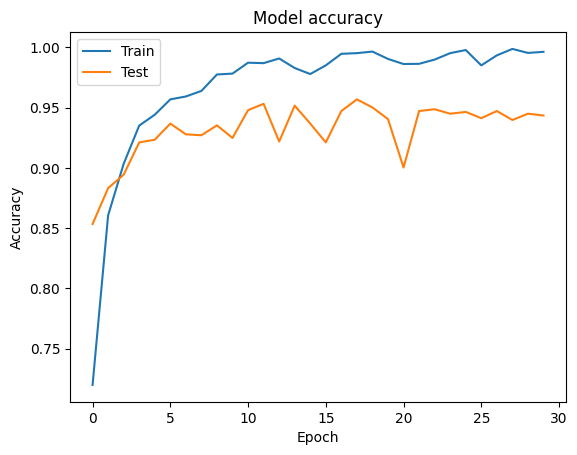

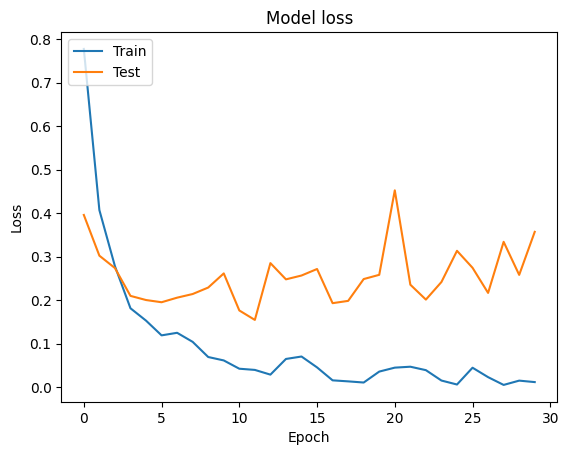

In [24]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [25]:
# Function to Load and Preprocess the Image using Pillow
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    # Load the image
    img = Image.open(image_path)
    # Resize the image
    img = img.resize(target_size)
    # Convert the image to a numpy array
    img_array = np.array(img)
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    # Scale the image values to [0, 1]
    img_array = img_array.astype('float32') / 255.
    return img_array

# Function to Predict the Class of an Image
def predict_image_class(model, image_path, class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_index]
    return predicted_class_name

In [26]:
# Create a mapping from class indices to class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}

In [27]:
class_indices

{0: 'Bacterial_Spot_Pepper',
 1: 'Common_Rust_Corn',
 2: 'Diseased_Cotton_Leaf',
 3: 'Diseased_Cotton_Plant',
 4: 'Gray_Leaf_Spot_Corn',
 5: 'Healthy_Corn',
 6: 'Healthy_Cotton_Leaf',
 7: 'Healthy_Cotton_Plant',
 8: 'Healthy_Pepper'}

In [28]:
json.dump(class_indices, open('class_indices.json', 'w'))

In [29]:
# Example Usage
image_path = '/content/Diseases/Diseased_Cotton_Plant/dd (1)_iaip.jpg'

predicted_class_name = predict_image_class(model, image_path, class_indices)

# Output the result
print("Predicted Class Name:", predicted_class_name)

1/1 [==============================] - 0s 385ms/step
Predicted Class Name: Diseased_Cotton_Plant


In [31]:
model.save('myprediction_model.h5')